In [23]:
# Working with dataframes
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Working with arrays/statistical functions
import numpy as np

# Managing directories
import os

%matplotlib inline

In [24]:
# List the available data

data_dir = '../data'
raw_data_dir = f'{data_dir}/raw'
print(os.listdir(raw_data_dir))


['test', 'train.csv', 'test.csv', 'train', 'sample_submission.csv']


In [25]:
# Read the files
train_csv_path = f'{raw_data_dir}/train.csv'
train_df = pd.read_csv(train_csv_path)

In [26]:
# General info about the data
train_df.info()

print('\nTotal records:',len(train_df['Patient']))
print('Unique patients:',len(train_df['Patient'].unique()))
print('Average records for a patient:',len(train_df['Patient'])/len(train_df['Patient'].unique()))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB

Total records: 1549
Unique patients: 176
Average records for a patient: 8.801136363636363


Since there are multiple records for a unique patient, let's create a column that represents a total number of records for each patient

Sex and SmokingStatus are categorical objects -> we'll have to encode them into numbers to make better analysis

In [27]:
def encodeSmokingStatus(patients_df):
    patients_df = patients_df.copy()
    smoking_statuses = patients_df['SmokingStatus'].unique()
    patients_df[smoking_statuses] = 0
    
    for j, smoking_status in enumerate(patients_df['SmokingStatus']):
        patients_df.loc[j, smoking_status] = 1
    return patients_df


train_df = encodeSmokingStatus(train_df)

In [28]:
def encodeSex(patients_df):
    patients_df = patients_df.copy()
    f_filt = patients_df['Sex'] == 'Female'
    m_filt = patients_df['Sex'] == 'Male'
    patients_df.loc[f_filt, 'Sex_n'] = 0
    patients_df.loc[m_filt, 'Sex_n'] = 1
    return patients_df

train_df = encodeSex(train_df)

In [29]:
train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Ex-smoker,Never smoked,Currently smokes,Sex_n
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,1,0,0,1.0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,1,0,0,1.0
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,1,0,0,1.0
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,1,0,0,1.0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,1,0,0,1.0


In [30]:
train_df.describe()

,Weeks,FVC,Percent,Age,Ex-smoker,Never smoked,Currently smokes,Sex_n
count,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000,1549.000000
mean,31.861846,2690.479019,77.672654,67.188509,0.670110,0.276953,0.052937,0.790187
std,23.247550,832.770959,19.823261,7.057395,0.470325,0.447638,0.223981,0.407306
min,-5.000000,827.000000,28.877577,49.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,2109.000000,62.832700,63.000000,0.000000,0.000000,0.000000,1.000000
50%,28.000000,2641.000000,75.676937,68.000000,1.000000,0.000000,0.000000,1.000000
75%,47.000000,3171.000000,88.621065,72.000000,1.000000,1.000000,0.000000,1.000000
max,133.000000,6399.000000,153.145378,88.000000,1.000000,1.000000,1.000000,1.000000


There are much more men in the dataset than women.
Also, the values in SmokingStatus are skewed towards Ex-smokers.

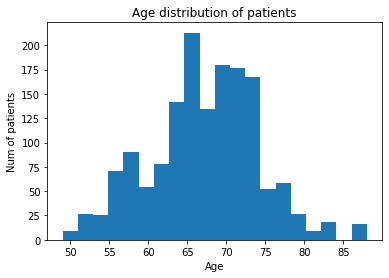

In [31]:
plt.title("Age distribution of patients")
plt.xlabel("Age")
plt.ylabel("Num of patients")
plt.hist(train_df.Age, bins=20)
plt.show()

Age is normally distributed so it would be best to standardize it before feeding it to our model

In [32]:
# Checking for missing values

print('Train data:\n',train_df.isna().sum(),'\n\n')

Train data:
 Patient             0
Weeks               0
FVC                 0
Percent             0
Age                 0
Sex                 0
SmokingStatus       0
Ex-smoker           0
Never smoked        0
Currently smokes    0
Sex_n               0
dtype: int64 




No values are missing.

In [33]:
from scipy.stats import pearsonr


def corr_table(df, corr_threshold=None, p_threshold=None):
    df = df._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            corr = round(pearsonr(df[r], df[c])[0], 4)
            p = round(pearsonr(df[r], df[c])[1], 4)
            

            if corr_threshold is not None and p_threshold is not None:
                if abs(corr) > corr_threshold and p < p_threshold:
                    pvalues[r][c] = corr
                else:
                    pvalues[r][c] = np.nan
                    
            elif p_threshold is not None:
                if p < p_threshold:
                    pvalues[r][c] = corr
                else:
                    pvalues[r][c] = np.nan
                    
            elif corr_threshold is not None:
                if abs(corr) > corr_threshold:
                    pvalues[r][c] = corr
                else:
                    pvalues[r][c] = np.nan
                    
            else:
                pvalues[r][c] = corr
    return pvalues


# Correlation between the features
corr_threshold = 0.01
p_threshold = 0.05


print(f'Correlations > {corr_threshold}, p < {p_threshold}')
corr_table(train_df, corr_threshold, p_threshold)

Correlations > 0.01, p < 0.05


,Weeks,FVC,Percent,Age,Ex-smoker,Never smoked,Currently smokes,Sex_n
Weeks,1,NaN,NaN,-0.0595,NaN,NaN,NaN,-0.0677
FVC,NaN,1,0.672,-0.0941,0.1611,-0.2425,0.1464,0.5029
Percent,NaN,0.672,1,0.0959,-0.0894,NaN,0.2377,-0.1214
Age,-0.0595,-0.0941,0.0959,1,0.0649,NaN,-0.0652,NaN
Ex-smoker,NaN,0.1611,-0.0894,0.0649,1,-0.8821,-0.337,0.3736
Never smoked,NaN,-0.2425,NaN,NaN,-0.8821,1,-0.1463,-0.3897
Currently smokes,NaN,0.1464,0.2377,-0.0652,-0.337,-0.1463,1,NaN
Sex_n,-0.0677,0.5029,-0.1214,NaN,0.3736,-0.3897,NaN,1


We can see that FVC is highly correlated with Percent, smoking status and sex. That is, males have generally higher FVC that females, Percent is obviously positively correlated with FVC, and those who are ex-smokers or smoke right now have higher FVC than those who never smoked. 

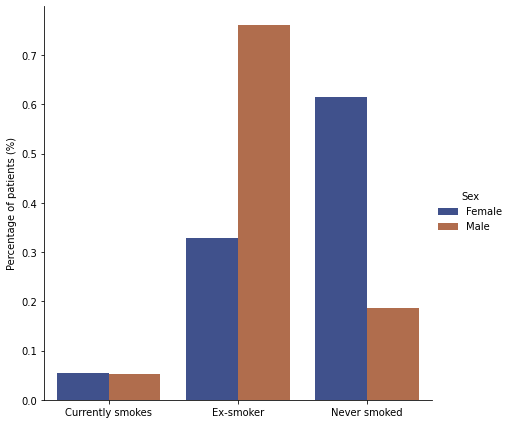

In [34]:
piv_tab = pd.pivot_table(train_df, index=['SmokingStatus', 'Sex'],
               values=['Patient'], 
               aggfunc={'Patient':'count'}).reset_index()

patients_f = piv_tab.loc[piv_tab['Sex']=='Female', 'Patient']
patients_m = piv_tab.loc[piv_tab['Sex']=='Male', 'Patient']

total_f = patients_f.sum()
total_m = patients_m.sum()

piv_tab.loc[piv_tab['Sex']=='Female','SmokingStatusPercentage'] = patients_f/total_f
piv_tab.loc[piv_tab['Sex']=='Male','SmokingStatusPercentage'] = patients_m/total_m

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=piv_tab, kind="bar",
    x="SmokingStatus", y="SmokingStatusPercentage", hue="Sex",
    palette="dark", alpha=.8, height=6
)


g.set_axis_labels("", "Percentage of patients (%)")

As we see, there are less smoking women than men in the dataset. Because we saw correlation between smoking and FVC, it can be purely due to the fact that more men smoke than women, so let's check if it's the case.

In [35]:
pd.pivot_table(train_df, index=['SmokingStatus', 'Sex'],
               values=['Patient', 'FVC','Percent'], 
               aggfunc={'Patient':'count', 'FVC':'mean', 'Percent':'mean'})

FVC  Patient     Percent
SmokingStatus    Sex                                     
Currently smokes Female  2868.833333       18  120.871764
                 Male    3300.828125       64   91.053710
Ex-smoker        Female  1901.906542      107   81.727499
                 Male    2886.024705      931   75.820578
Never smoked     Female  1775.985000      200   79.202967
                 Male    2878.034934      229   74.835884

People who are ex-smokers or currently smoke generally have larger FVC than those who never smoked regardless of their gender. Thus, smoking status directly have influence on FVC.

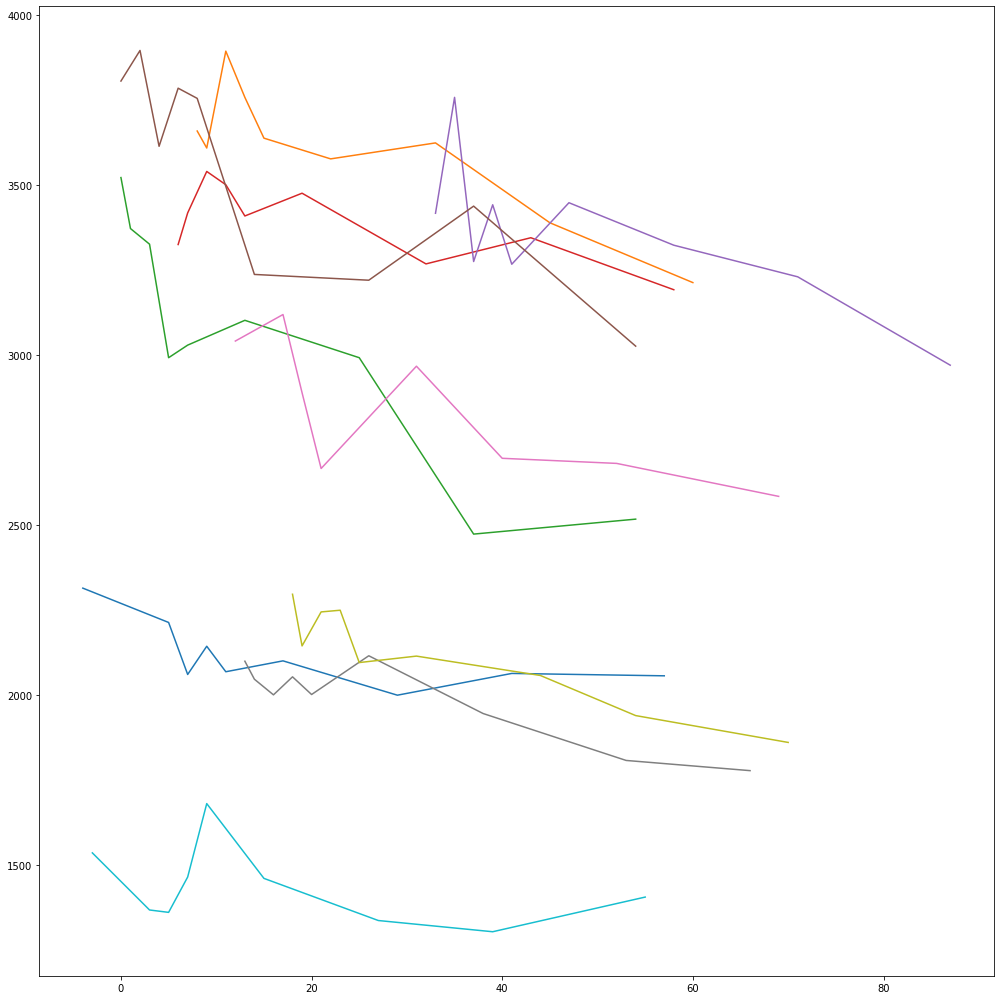

In [36]:
# FVC and weeks graphs for first 10 patients
weeks_x = []
FVC_y = []
for ID in train_df['Patient'].unique()[:10]:
    weeks_x.append(train_df.loc[train_df['Patient'] == ID, 'Weeks'])
    FVC_y.append(train_df.loc[train_df['Patient'] == ID, 'FVC'])


plt.figure(figsize=[14,14])

for i, j in zip(weeks_x, FVC_y):
    plt.plot(i, j)
    
plt.tight_layout()
plt.show()


In [37]:
# Std and mean of features for further standardization during modeling process
weeks_std = train_df.Weeks.std()
weeks_mean = train_df.Weeks.mean()

fvc_std = train_df.FVC.std()
fvc_mean = train_df.FVC.mean()

age_std = train_df.Age.std()
age_mean = train_df.Age.mean()


print(f"weeks_std - {weeks_std}, weeks_mean - {weeks_mean}")
print(f"fvc_std - {fvc_std}, fvc_mean - {fvc_mean}")
print(f"age_std - {age_std}, age_mean - {age_mean}")


weeks_std - 23.247550440817225, weeks_mean - 31.861846352485475
fvc_std - 832.7709592986733, fvc_mean - 2690.479018721756
age_std - 7.057394616249352, age_mean - 67.18850871530019


## Preprocessing Dicom images of CT scans

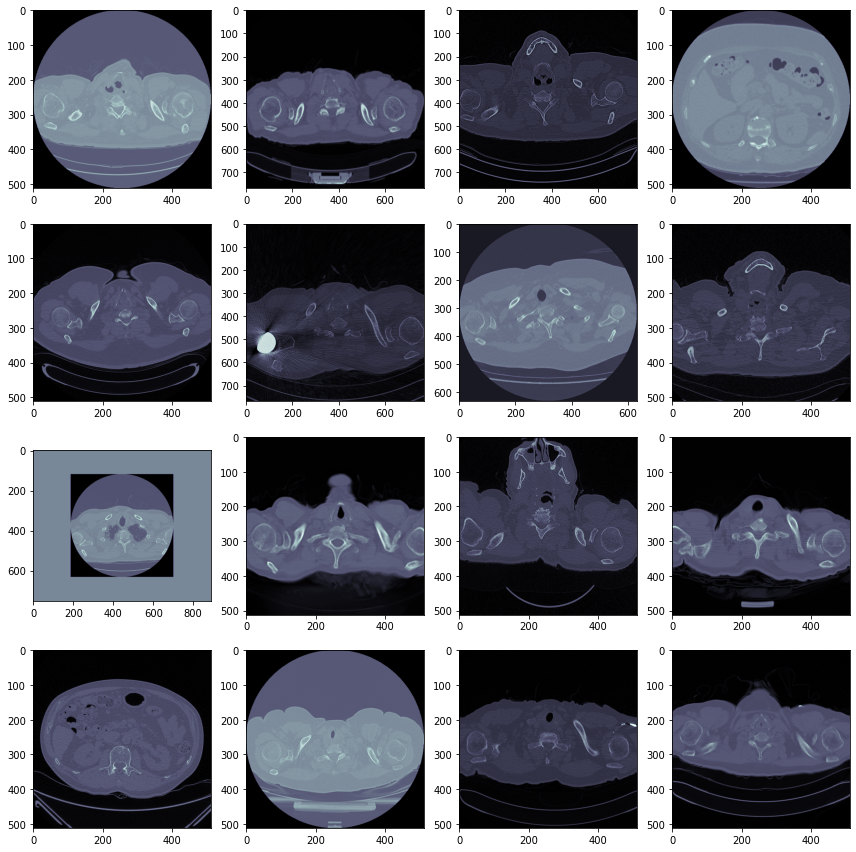

In [38]:
import pydicom as dicom
from collections import defaultdict
import math
from PIL import Image

dcm_path = f'{raw_data_dir}/train'

plt.figure(figsize=(12,12))

for i, key in enumerate(os.listdir(dcm_path)[:16], start=1):
    dcm_img = dicom.read_file(f"{dcm_path}/{key}/1.dcm")
    dcm_img_array = dcm_img.pixel_array
    plt.subplot(4,4,i)
    plt.imshow(dcm_img_array, plt.cm.bone)
    
plt.tight_layout()

Images are on different scales, some of them need to be cropped. Also, most of them need to be transformed to Hounsfield Units which is common scale for medical CT imaging. Here are some values from HU scale and what they represent:
![HU Scale](HUScale.jpg "HU Scale")

In [39]:
def crop_image(img):
    mask = img != img[0, 0]

    ix = np.ix_(mask.any(1), mask.any(0))
    return img[ix]

def get_dcm_uh(patients_dir, num=None, save_folder=None, return_type=None):
    dcm_img_arrays = defaultdict(list)
    patient_ids = os.listdir(patients_dir)

    if num is None or num > len(patient_ids):
        num = len(patient_ids)

    for i, patient_id in enumerate(patient_ids[:num]):
        try:
            patient_path = os.path.join(patients_dir, patient_id)

            dcm_names = np.array([dcm_name[:-4] for dcm_name in os.listdir(patient_path)], dtype=int)
            dcm_names = sorted(list(dcm_names))

            # Getting 15 evenly spaced dcms from the dcm_names
            len_dcm_names = len(dcm_names)
            desired_len = 15
            dcm_names = dcm_names[0::max(1, math.floor(len_dcm_names / desired_len))]
            while len(dcm_names) > 15:
                del dcm_names[-1]
            while len(dcm_names) < 15:
                dcm_names.append(dcm_names[-1])

            patient_dcm_paths = [f'{patients_dir}/{patient_id}/{dcm_num}.dcm' for dcm_num in dcm_names]

            for j, dcm_img_path in enumerate(patient_dcm_paths, start=1):
                dcm_img = dicom.read_file(dcm_img_path)
                dcm_img_array = dcm_img.pixel_array
                
                # Transforming dcm image to HU
                if dcm_img_array.shape[0] != dcm_img_array.shape[1]:
                    dcm_img_array = crop_image(dcm_img_array)
                    dcm_img_array = dcm_img_array + 1024
                    dcm_img_array[dcm_img_array == np.min(dcm_img_array)] = 0
                    dcm_img_array = dcm_img_array - 1024
                else:
                    dcm_img_array[dcm_img_array < -1024] = -1024

                slope = int(dcm_img.RescaleSlope)
                intercept = int(dcm_img.RescaleIntercept)
                dcm_img_array = dcm_img_array * slope + intercept
                dcm_img_array[dcm_img_array < -1024] = -1024

                # Deciding the way to store and return the dcms
                if return_type == 'array':
                    dcm_img_arrays[patient_id].append(dcm_img_array)
                elif return_type == 'dcm':
                    dcm_img.pixel_array = dcm_img_array
                    dcm_img_arrays[patient_id].append(dcm_img)
                elif return_type is None:
                    pass
                
                
                # Saving the processed files if requested
                if save_folder:
                    if not os.path.isdir(save_folder):
                        os.mkdir(save_folder)


                    patient_folder = os.path.join(save_folder, patient_id)
                    if not os.path.isdir(patient_folder):
                        os.mkdir(patient_folder)

                    new_dcm_img_path = os.path.join(patient_folder, f'{j}.npy')

                    dcm_img_array = Image.fromarray(dcm_img_array)
                    size = (512, 512)
                    dcm_img_array = dcm_img_array.resize(size)
                    dcm_img_array = np.array(dcm_img_array)

                    np.save(new_dcm_img_path, dcm_img_array)
                    
                
        except RuntimeError as err:
            print(f'Runtime error on patient {patient_id}:\n{err}')

        print(f'Patient {patient_id} - done. {num - i - 1} patients left.')
    return dcm_img_arrays


# Get data in HUs + save

dcm_path = f'{raw_data_dir}/train'

hu_data = get_dcm_uh(dcm_path, return_type='array', num=None) 

# save_folder_path = '../data/processed/train'
# get_dcm_uh(dcm_path, return_type=None, num=None, save_folder=save_folder_path) 


Patient ID00125637202218590429387 - done. 175 patients left.
Patient ID00291637202279398396106 - done. 174 patients left.
Patient ID00009637202177434476278 - done. 173 patients left.
Patient ID00020637202178344345685 - done. 172 patients left.
Patient ID00093637202205278167493 - done. 171 patients left.
Patient ID00351637202289476567312 - done. 170 patients left.
Patient ID00288637202279148973731 - done. 169 patients left.
Patient ID00224637202259281193413 - done. 168 patients left.
Patient ID00094637202205333947361 - done. 167 patients left.
Patient ID00139637202231703564336 - done. 166 patients left.
Patient ID00060637202187965290703 - done. 165 patients left.
Patient ID00392637202302319160044 - done. 164 patients left.
Patient ID00393637202302431697467 - done. 163 patients left.
Patient ID00048637202185016727717 - done. 162 patients left.
Patient ID00111637202210956877205 - done. 161 patients left.
Patient ID00331637202286306023714 - done. 160 patients left.
Patient ID00117637202212

Patient ID00025637202179541264076 - done. 36 patients left.
Patient ID00173637202238329754031 - done. 35 patients left.
Patient ID00165637202237320314458 - done. 34 patients left.
Patient ID00186637202242472088675 - done. 33 patients left.
Patient ID00279637202272164826258 - done. 32 patients left.
Patient ID00234637202261078001846 - done. 31 patients left.
Patient ID00222637202259066229764 - done. 30 patients left.
Patient ID00051637202185848464638 - done. 29 patients left.
Patient ID00109637202210454292264 - done. 28 patients left.
Patient ID00370637202296737666151 - done. 27 patients left.
Patient ID00360637202295712204040 - done. 26 patients left.
Patient ID00042637202184406822975 - done. 25 patients left.
Patient ID00110637202210673668310 - done. 24 patients left.
Patient ID00082637202201836229724 - done. 23 patients left.
Patient ID00132637202222178761324 - done. 22 patients left.
Patient ID00337637202286839091062 - done. 21 patients left.
Patient ID00241637202264294508775 - done

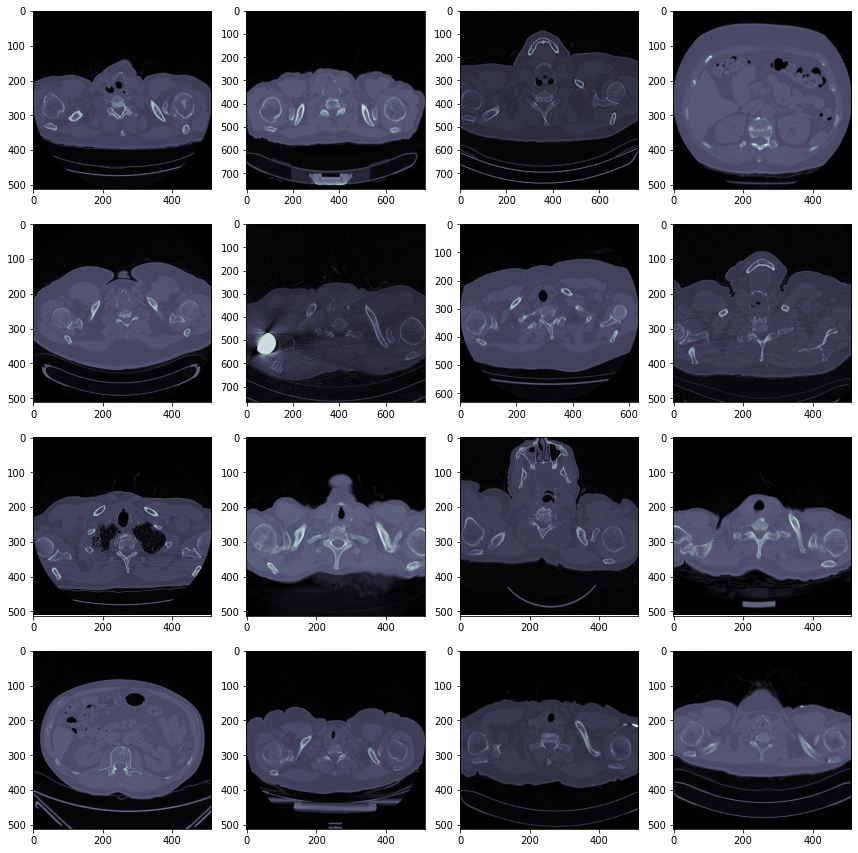

In [40]:
plt.figure(figsize=(12,12))

for i, key in enumerate(os.listdir(dcm_path)[:16], start=1):
    plt.subplot(4,4,i)
    plt.imshow(hu_data[key][0], plt.cm.bone)
    
plt.tight_layout()

We successfully transformed all the dcms to the Hounsfield Units scale.

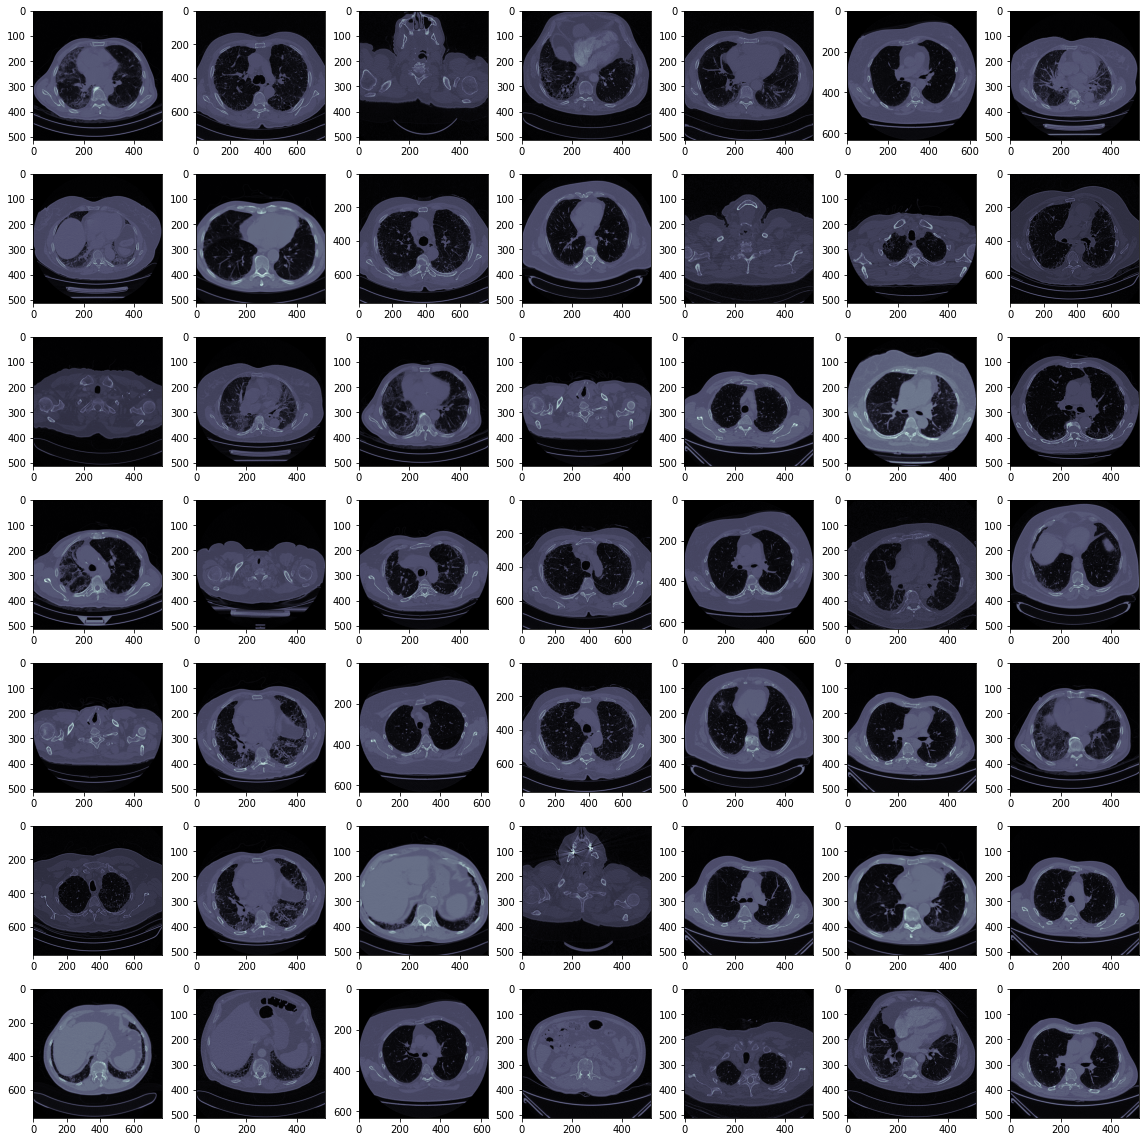

In [41]:
# Plot 49 random dcm images to show how good the hu scaling is
def plot_random_dcms(hu_data):
    patient_indices = np.random.randint(0, 15, [49, ])
    image_indices = np.random.randint(0, 15, [15, ])
    plt.figure(figsize=(16, 16))
    for i, patient_index in enumerate(patient_indices):
        plt.subplot(7, 7, i + 1)
        plt.imshow(list(hu_data.values())[patient_index][np.random.choice(image_indices)], plt.cm.bone)
    plt.tight_layout()
    plt.show()

plot_random_dcms(hu_data)

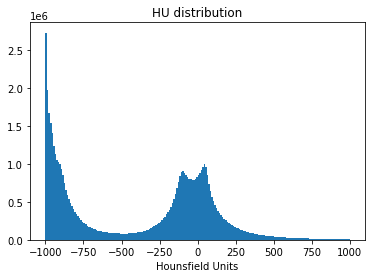

In [42]:
def get_hu_distribution(hu_data, patients_range, hist_bins=200, hu_range=None, concat=False):
    total_hu_data = np.array([])

    if len(hu_data) > 1:
        hu_data = hu_data.values()

    plt.title("HU distribution")
    plt.xlabel("Hounsfield Units")
    
    if concat:
        for patient in list(hu_data)[patients_range[0]:patients_range[1]]:
            patient = np.array(patient).flatten()
            total_hu_data = np.concatenate((total_hu_data, patient))

        plt.hist(total_hu_data, bins=hist_bins, range=hu_range)
        plt.show()

    else:
        plt.hist(hu_data, bins=hist_bins, range=hu_range)
        plt.show()
    
    
        
get_hu_distribution(hu_data, [0, 15], 200, [-1000, 1000], True)


In [43]:
# ==================================#
# Get number of dicom images for each patient
nums_of_dcms = []
for patient_dir in os.listdir(dcm_path):
    num_of_dcms = len(os.listdir(os.path.join(dcm_path, patient_dir)))

    nums_of_dcms.append(num_of_dcms)
    


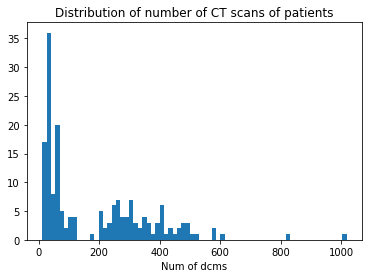

In [44]:
plt.figure()
plt.title('Distribution of number of CT scans of patients')
plt.xlabel('Num of dcms')
plt.hist(nums_of_dcms, bins=70)
plt.show()